# Preparing the Dataset

**Data flow:**

Current images are in jpeg and .xml annotation format.
* Filter "ZEAMX" (which represents maize) from the annotation files.
* Resize the images from 3000x1296 to 1024x448 which is downsizing on average by a factor of (2.91).
* Divide the annotation coordinates by a factor of 2.91

* Save a Zipped file.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import shutil
from PIL import Image
import matplotlib.patches as patches
import random

### Filter the XML files such that only maize is labelled and change the format to .txt file in yolo

In [2]:
def convert_bbox(size, box):
  dw = 1. / size[0]
  dh = 1. / size[1]
  x = (box[0] + box[1]) / 2.0
  y = (box[2] + box[3]) / 2.0
  w = box[1] - box[0]
  h = box[3] - box[2]
  x = x * dw
  w = w * dw
  y = y * dh
  h = h * dh
  return (x, y, w, h)

def filter_maize_and_change_annotation_format(source_dir, new_dir, target_size=(640, 640)):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    def filter_xml_objects_and_convert(xml_file_path, new_txt_file_path, label_contains='ZEAM', new_label='0', target_size=(1024, 448)):
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        size = root.find('size')
        original_width = int(size.find('width').text)
        original_height = int(size.find('height').text)
        ratio_width = target_size[0] / original_width
        ratio_height = target_size[1] / original_height

        with open(new_txt_file_path, 'w') as new_file:
            contains_required_label = False
            for obj in root.findall('object'):
                if label_contains in obj.find('name').text:
                    xmlbox = obj.find('bndbox')
                    xmin = float(xmlbox.find('xmin').text) * ratio_width
                    xmax = float(xmlbox.find('xmax').text) * ratio_width
                    ymin = float(xmlbox.find('ymin').text) * ratio_height
                    ymax = float(xmlbox.find('ymax').text) * ratio_height
                    # Convert to YOLO format
                    bb = convert_bbox(target_size, (xmin, xmax, ymin, ymax))
                    new_file.write(f"{new_label} {' '.join([str(a) for a in bb])}\n")
                    contains_required_label = True

            return contains_required_label

    xml_files = [f for f in os.listdir(source_dir) if f.endswith('.xml')]

    for xml_file in xml_files:
        xml_file_path = os.path.join(source_dir, xml_file)
        new_txt_file_name = xml_file.replace('.xml', '.txt')
        new_txt_file_path = os.path.join(new_dir, new_txt_file_name)

        if filter_xml_objects_and_convert(xml_file_path, new_txt_file_path):
            # Copy and resize the corresponding image
            jpg_file = xml_file.replace('.xml', '.JPG')
            original_jpg_path = os.path.join(source_dir, jpg_file)
            new_jpg_path = os.path.join(new_dir, jpg_file)
            # Resize image
            with Image.open(original_jpg_path) as img:
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img.save(new_jpg_path)

    print(f"Filtered XML files and images are saved in: {new_dir}")

In [5]:
# filter_maize_and_change_annotation_format('train_set', 'new_train_set')
# filter_maize_and_change_annotation_format('validation_set', 'new_validation_set')
# filter_maize_and_change_annotation_format('test_set', 'new_test_set')

Filtered XML files and images are saved in: new_validation_set
Filtered XML files and images are saved in: new_test_set


### Visualize the images and the annotations

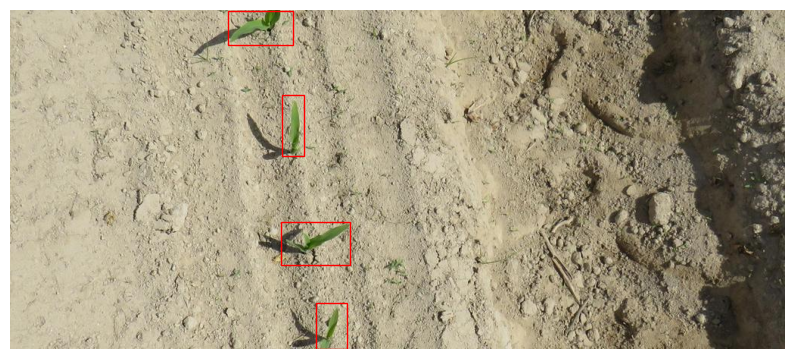

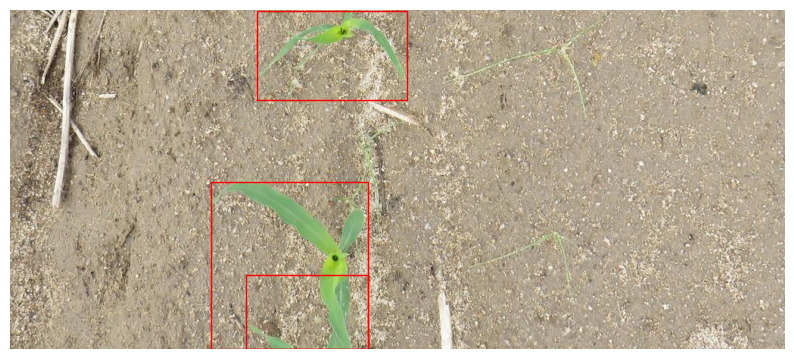

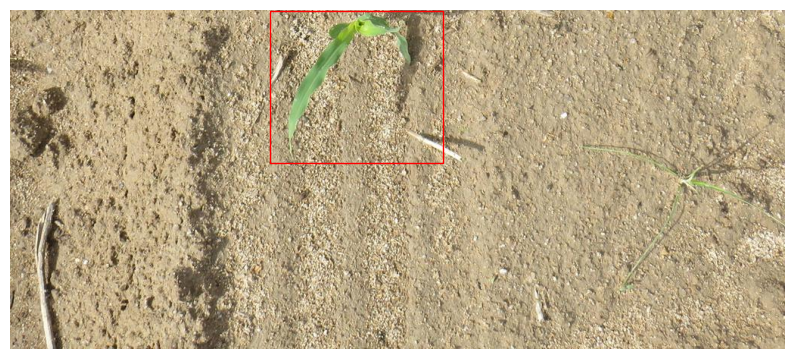

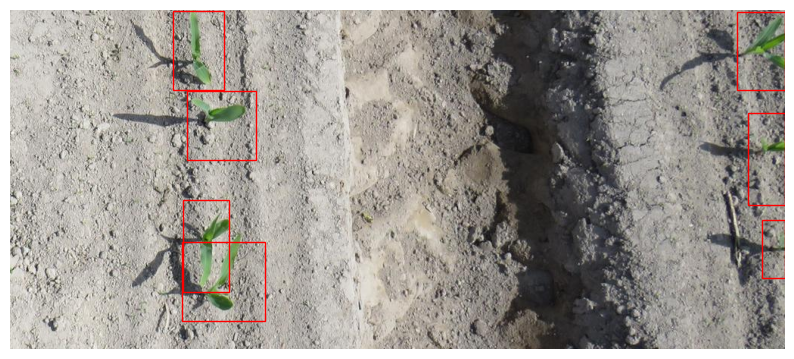

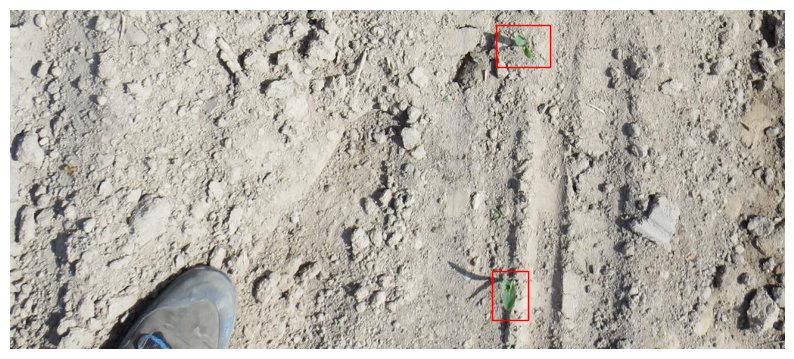

In [7]:
def display_images_with_annotations_one_by_one(folder_path, n=5):
    # Get all the image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    # Select n random images
    selected_files = random.sample(image_files, n)
    annotation_files = [f.replace('.JPG', '.txt') for f in selected_files]
    
    # Display each image with annotations separately
    for img_file, ann_file in zip(selected_files, annotation_files):
        # Open image
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Display image
        ax.imshow(img)
        ax.axis('off')  # Hide the axis
        
        # If annotation file exists, display it
        ann_path = os.path.join(folder_path, ann_file)
        if os.path.exists(ann_path):
            with open(ann_path, 'r') as file:
                annotations = file.readlines()
                for ann in annotations:
                    # Parse the annotation
                    class_id, x_center, y_center, width, height = map(float, ann.strip().split())
                    # Convert from YOLO format to matplotlib rectangle format
                    x_center *= img.width
                    y_center *= img.height
                    width *= img.width
                    height *= img.height
                    # Convert to top-left x, y, with width and height
                    x_top_left = x_center - (width / 2)
                    y_top_left = y_center - (height / 2)
                    # Create a rectangle patch
                    rect = patches.Rectangle((x_top_left, y_top_left), width, height, 
                                             linewidth=1, edgecolor='r', facecolor='none')
                    # Add the rectangle to the plot
                    ax.add_patch(rect)
        
        plt.show()

folder_path = 'new_train_set'
display_images_with_annotations_one_by_one(folder_path)